# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx, subgraph, k_hop_subgraph
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import random

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Cora Dataset

In [4]:
dataset = Planetoid(root="../data/Cora", name="Cora")
data = dataset[0]

In [5]:
node_of_interest = random.randint(0, data.num_nodes - 1)
print("Node of Interest:", node_of_interest)

# extract 2-hop subgraph
subset_nodes, sub_edge_index, _, _ = k_hop_subgraph(
    node_of_interest, 
    num_hops=2, 
    edge_index=data.edge_index, 
    relabel_nodes=True
)

sub_x = data.x[subset_nodes]
sub_y = data.y[subset_nodes]

print("Subgraph Nodes:", sub_x.size(0))

Node of Interest: 2619
Subgraph Nodes: 2


In [6]:
# G = to_networkx(
#     Data(x=sub_x, edge_index=sub_edge_index), 
#     to_undirected=True
# )

# plt.figure(figsize=(6,6))
# nx.draw(G, node_size=50)
# plt.title("Subgraph (2-hop Neighborhood)")
# plt.show()

In [7]:
#Jumlah Node
data.num_nodes

2708

In [8]:
#jumlah edge
data.num_edges

10556

In [9]:
#dimensi fitur
data.num_features

1433

In [10]:
#jumlah keasl
dataset.num_classes

7

In [11]:
#nama kelas
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [12]:
#nodes belong to classes
data.y.bincount()

tensor([351, 217, 418, 818, 426, 298, 180])

In [13]:
class_counts = data.y.bincount()
for class_idx in range(len(class_counts)):
    print(f"Kelas {class_idx}: {class_counts[class_idx].item()} nodes")

Kelas 0: 351 nodes
Kelas 1: 217 nodes
Kelas 2: 418 nodes
Kelas 3: 818 nodes
Kelas 4: 426 nodes
Kelas 5: 298 nodes
Kelas 6: 180 nodes


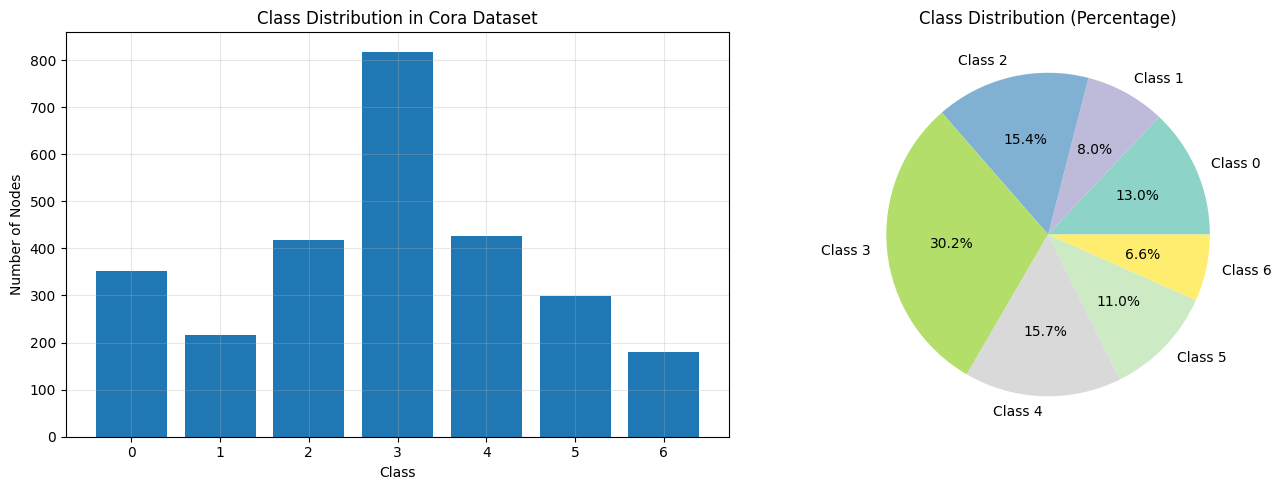

In [14]:
class_counts = data.y.bincount()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of class distribution
axes[0].bar(range(len(class_counts)), class_counts.numpy())
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Nodes')
axes[0].set_title('Class Distribution in Cora Dataset')
axes[0].grid(True, alpha=0.3)

# Pie chart of class distribution
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
axes[1].pie(class_counts.numpy(), labels=[f'Class {i}' for i in range(len(class_counts))], 
            autopct='%1.1f%%', colors=colors)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

In [15]:
#train nodes
data.train_mask.sum().item()

140

In [16]:
print(f"\nTrain ratio: {data.train_mask.sum().item()/data.num_nodes:.2%}")


Train ratio: 5.17%


In [17]:
#validation nodes
data.val_mask.sum().item()

500

In [18]:
print(f"Validation ratio: {data.val_mask.sum().item()/data.num_nodes:.2%}")

Validation ratio: 18.46%


In [19]:
#test nodes
data.test_mask.sum().item()

1000

In [20]:
print(f"Test ratio: {data.test_mask.sum().item()/data.num_nodes:.2%}")

Test ratio: 36.93%


In [21]:
data.edge_index.shape

torch.Size([2, 10556])

In [22]:
data.edge_index[:, :5]

tensor([[ 633, 1862, 2582,    2,  652],
        [   0,    0,    0,    1,    1]])

In [23]:
data.x[0, :10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
node_of_interest = 100  # Fixed for consistent visualization
print(f"Node of Interest: {node_of_interest} (Class: {data.y[node_of_interest].item()})")

Node of Interest: 100 (Class: 0)


In [25]:
# Extract 2-hop subgraph
subset_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_of_interest, 
    num_hops=2, 
    edge_index=data.edge_index, 
    relabel_nodes=True,
    num_nodes=data.num_nodes
)

sub_x = data.x[subset_nodes]
sub_y = data.y[subset_nodes]

print(f"Subgraph contains {sub_x.size(0)} nodes")
print(f"Classes in subgraph: {torch.unique(sub_y).tolist()}")

Subgraph contains 19 nodes
Classes in subgraph: [0, 1]


(np.float64(-1.017894484376819),
 np.float64(1.051741356398683),
 np.float64(-1.201614913338278),
 np.float64(1.1217569451314033))

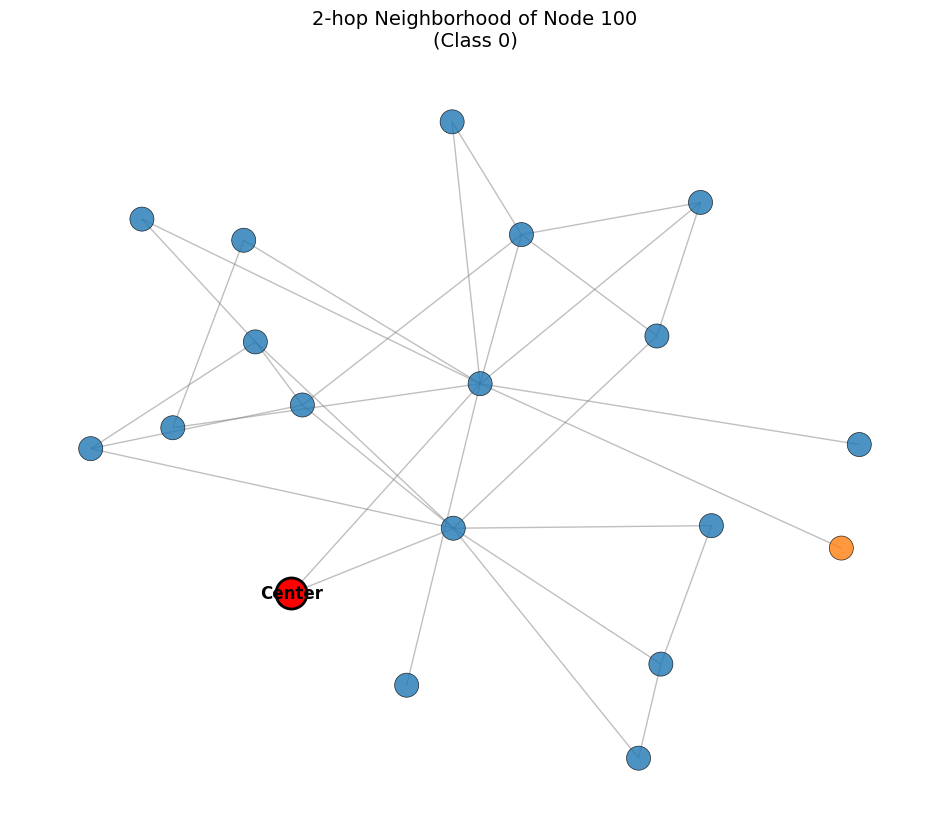

In [26]:
# Convert to NetworkX for visualization
subgraph_data = Data(x=sub_x, edge_index=sub_edge_index)
G = to_networkx(subgraph_data, to_undirected=True)

plt.figure(figsize=(12, 10))

# Create color map for classes
cmap = plt.cm.tab10
node_colors = [cmap(y) for y in sub_y.numpy()]

# Get positions using spring layout
pos = nx.spring_layout(G, seed=42, k=1)

# Highlight the center node
center_idx = (subset_nodes == node_of_interest).nonzero(as_tuple=True)[0].item()

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=300, 
                       node_color=node_colors, 
                       alpha=0.8, 
                       linewidths=0.5,
                       edgecolors='black')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')

# Highlight center node
nx.draw_networkx_nodes(G, pos, nodelist=[center_idx], 
                       node_size=500, 
                       node_color='red',
                       edgecolors='black', 
                       linewidths=2)

# Add labels for the center node
labels = {center_idx: 'Center'}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold')

plt.title(f"2-hop Neighborhood of Node {node_of_interest}\n(Class {data.y[node_of_interest].item()})", fontsize=14)
plt.axis('off')

In [27]:
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=cmap(i), label=f'Class {i}') 
#                    for i in range(dataset.num_classes)]
# plt.legend(handles=legend_elements, loc='upper right', title="Classes")

# plt.tight_layout()
# plt.show()

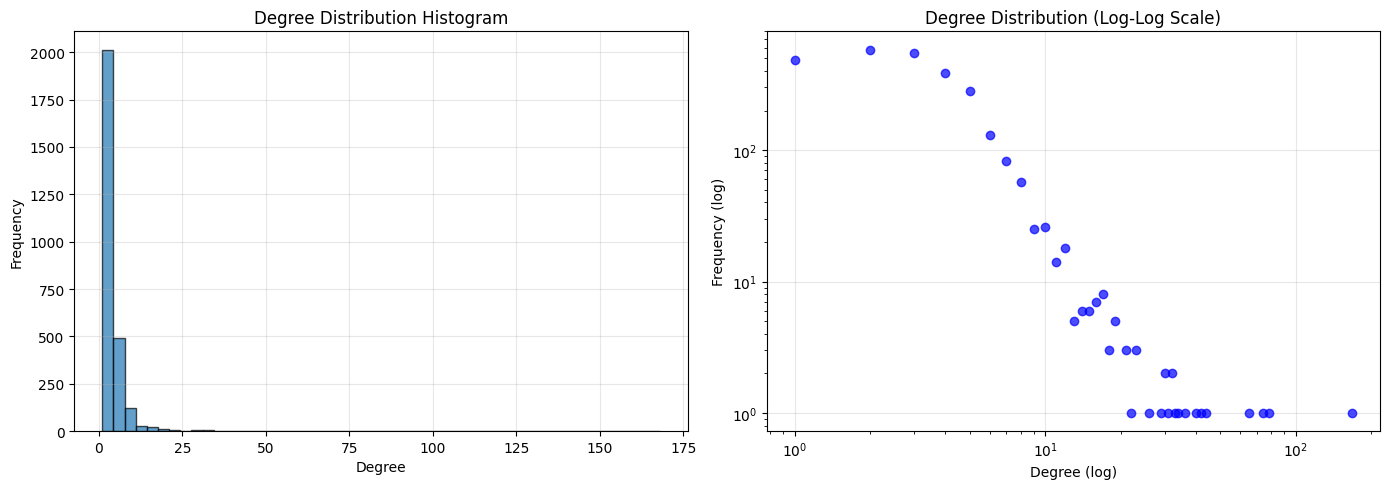

In [28]:
degrees = np.zeros(data.num_nodes)
for i in range(data.num_nodes):
    degrees[i] = (data.edge_index[0] == i).sum().item()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of degree distribution
axes[0].hist(degrees, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Distribution Histogram')
axes[0].grid(True, alpha=0.3)

# Log-log plot for power law check
unique_degrees, degree_counts = np.unique(degrees, return_counts=True)
axes[1].loglog(unique_degrees, degree_counts, 'bo', alpha=0.7)
axes[1].set_xlabel('Degree (log)')
axes[1].set_ylabel('Frequency (log)')
axes[1].set_title('Degree Distribution (Log-Log Scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
print(f"• Average degree: {degrees.mean():.2f}")
print(f"• Maximum degree: {degrees.max():.0f}")
print(f"• Minimum degree: {degrees.min():.0f}")

• Average degree: 3.90
• Maximum degree: 168
• Minimum degree: 1


# PRA-PROSES (Message Passing Layer)

$h_u^{(k)} = \sum W_{\text{msg}} \cdot h_u^{(k-1)} + W_{\text{self}} \cdot h_v^{(k-1)}$

 di mana,
 1. **k** adalah urutan lapisan GNN.
 2. **Wmsg** adalah bobot yang diakses bersama dengan neighborhood nodes.
 3. **Wself** adalah bobot milik node asal (v).

In [30]:
class CustomMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.W_msg = nn.Linear(in_channels, out_channels)  # For neighbors
        self.W_self = nn.Linear(in_channels, out_channels) # For self
        
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.W_msg(x_j)
    
    def update(self, aggr_out, x):
        return aggr_out + self.W_self(x)

In [31]:
# class CustomMessagePassing(MessagePassing):
#     def __init__(self, in_channels, out_channels, aggr='add'):
#         super().__init__(aggr=aggr)
#         self.W_msg = nn.Linear(in_channels, out_channels)
#         self.W_self = nn.Linear(in_channels, out_channels)
        
#     def forward(self, x, edge_index):
#         return self.propagate(edge_index, x=x)
    
#     def message(self, x_j):
#         return self.W_msg(x_j)
    
#     def update(self, aggr_out, x):
#         return aggr_out + self.W_self(x)

In [32]:
# TEST MESSAGE PASSING

test_mp = CustomMessagePassing(in_channels=16, out_channels=32)
test_mp

CustomMessagePassing()

In [33]:
test_mp.W_msg.weight.shape

torch.Size([32, 16])

In [34]:
test_mp.W_self.weight.shape

torch.Size([32, 16])

# Intra-layer GNN Block

$$
\mathbf{h}_v^{(k)} =
\text{ACT}\!\left(
    \text{Dropout}\!\left(
        \text{BatchNorm}\!\left(
            \mathbf{W}^{(k-1)}\,\mathbf{h}_v^{(k-1)} + \mathbf{b}^{(k-1)}
        \right)
    \right)
\right)
+ \mathbf{h}_v^{(k-1)}
$$


di mana:

1. **ACT** adalah fungsi aktivasi yang Anda pilih.
2. **BatchNorm** adalah `1D-Batch Normalization`.


## DEFINE SINGLE GNN LAYER 

In [35]:
class GNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        
        self.message_passing = CustomMessagePassing(in_channels, out_channels)
        
        # Post-message-passing processing
        self.linear = nn.Linear(out_channels, out_channels)
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        
        # Residual connection
        if in_channels != out_channels:
            self.residual = nn.Linear(in_channels, out_channels)
        else:
            self.residual = nn.Identity()
    
    def forward(self, x, edge_index):
        x_input = x
        
        # Message passing
        x_mp = self.message_passing(x, edge_index)
        
        # Process features
        x_linear = self.linear(x_mp)
        x_bn = self.batch_norm(x_linear)
        x_drop = self.dropout(x_bn)
        x_act = self.activation(x_drop)
        
        # Residual connection
        x_residual = self.residual(x_input)
        return x_act + x_residual

## Test GNN Layer

In [36]:
test_layer = GNNLayer(in_channels=16, out_channels=32)
test_layer

GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=32, out_features=32, bias=True)
  (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Linear(in_features=16, out_features=32, bias=True)
)

In [37]:
test_layer.batch_norm

BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [38]:
test_layer.dropout.p

0.5

In [39]:
test_layer.activation

ReLU()

# Full Model with k>1 Layers

## Build Model

In [40]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes, num_layers=4):
        super().__init__()
        
        self.input_proj = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            if i == num_layers - 1:
                self.layers.append(GNNLayer(hidden_channels, out_channels, dropout=0.3))
            else:
                self.layers.append(GNNLayer(hidden_channels, hidden_channels, dropout=0.5))
        
        # Classifier now knows number of classes
        self.classifier = nn.Linear(out_channels, num_classes)
    
    def forward(self, x, edge_index):
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)


## Initialize Model

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [42]:
# model = GNNModel(
#     in_channels=data.num_features,
#     hidden_channels=512,
#     out_channels=dataset.num_classes
# ).to(device)

# print(f"Model created on {device}")

In [43]:
# model = GNNModel(
#     in_channels=data.num_features,
#     hidden_channels=256,
#     out_channels=dataset.num_classes
# ).to(device)

In [44]:
out_classes = dataset.num_classes

In [ ]:
model = GNNModel(
    in_channels=1433,     
    hidden_channels=128,  
    out_channels=128,     
    num_classes=7,       
    num_layers=4
)

In [46]:
# model.classifier = nn.Linear(128, out_classes).to(device)

In [47]:
model.classifier = nn.Linear(128, out_classes).to(device)

## RAINING LOOP WITH VALIDATION LOSS

### DEFINE TRAINING STEP FUNCTION

In [48]:
def train_one_epoch(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    
    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()

### DEFINE EVALUATION FUNCTION

In [49]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()
    return accuracy

In [50]:
data = data.to(device)

In [51]:
# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)

In [52]:
# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

In [53]:
# Training parameters
patience = 30
best_val_acc = 0
patience_counter = 0
epochs = 200

In [54]:
train_losses = []
val_accuracies = []
test_accuracies = []

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Move data
data = data.to(device)


In [56]:
for epoch in range(epochs):
    # Training
    loss = train_one_epoch(model, data, optimizer)
    train_losses.append(loss)
    
    # Evaluation
    val_acc = evaluate(model, data, data.val_mask)
    test_acc = evaluate(model, data, data.test_mask)
    
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    # Update scheduler
    scheduler.step()
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), '../models/best_model.pth')
    else:
        patience_counter += 1
    
    # Progress reporting
    if epoch % 10 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch:3d}: Loss={loss:.4f}, Val={val_acc:.4f}, Test={test_acc:.4f}, LR={lr:.6f}')
    
    # Early stopping
    if patience_counter >= patience:
        print(f'\nEarly stopping at epoch {epoch}')
        break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2708x1433 and 7x128)

In [ ]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    
    # Calculate final accuracies
    train_pred = out[data.train_mask].argmax(dim=1)
    train_acc = (train_pred == data.y[data.train_mask]).float().mean().item()
    
    val_pred = out[data.val_mask].argmax(dim=1)
    val_acc = (val_pred == data.y[data.val_mask]).float().mean().item()
    
    test_pred = out[data.test_mask].argmax(dim=1)
    test_acc = (test_pred == data.y[data.test_mask]).float().mean().item()